# Import

In [3]:
import pandas as pd
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from __future__ import print_function

# Standard libraries
import os
import time
import random
import warnings
from math import sqrt, pow

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Deep learning
import tensorflow as tf
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
import keras
from keras import backend as K

# Optimization
from scipy import optimize
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from hyperopt import fmin, tpe, Trials, hp, STATUS_OK


%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def set_seed2(SEED):
  SEED = 42
  os.environ['PYTHONHASHSEED'] = str(SEED)
  random.seed(SEED)
  np.random.seed(SEED)
  tf.random.set_seed(SEED)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Appeler la fonction pour fixer le seed
set_seed(SEED)


# Methode

In [4]:
# read the train and test data
def prep_data(train, test, drop_sensors, remaining_sensors, alpha, drop = True):
    if drop:
        X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
        X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))
    else:
        X_train_interim = add_operating_condition(train)
        X_test_interim = add_operating_condition(test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)
    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)

    return X_train_interim, X_test_interim

def rul_piecewise_fct(X_train, rul):

    X_train['RUL'].clip(upper=rul, inplace=True)

    return X_train

def prepare_data(file_name):
    dir_path = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/'
    dependent_var = ['RUL']
    index_names = ['Unit', 'Cycle']
    setting_names = ['Altitude', 'Mach', 'TRA']
    sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
    col_names = index_names + setting_names + sensor_names

    df_train = pd.read_csv(dir_path+'train_'+str(file_name),delim_whitespace=True,names=col_names)

    rul_train = pd.DataFrame(df_train.groupby('Unit')['Cycle'].max()).reset_index()
    rul_train.columns = ['Unit', 'max']
    df_train = df_train.merge(rul_train, on=['Unit'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(dir_path+'test_'+str(file_name), delim_whitespace=True, names=col_names)

    y_test = pd.read_csv(dir_path+'RUL_'+(file_name), delim_whitespace=True,names=["RUL"])
    #y_true["Unit"] = y_true.index + 1
    return df_train, df_test, y_test


# add operational condition to then normalize the data based on these operational conditions test
def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['Altitude'] = df_op_cond['Altitude'].round()
    df_op_cond['Mach'] = df_op_cond['Mach'].round(decimals=2)
    df_op_cond['TRA'] = df_op_cond['TRA'].round()

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['Altitude'].astype(str) + '_' + \
                        df_op_cond['Mach'].astype(str) + '_' + \
                        df_op_cond['TRA'].astype(str)

    return df_op_cond

# normalize the data based on the operational condition
def condition_scaler(df_train, df_test, sensor_names):
  # apply operating condition specific scaling
  #scaler = StandardScaler()
    scaler = MinMaxScaler(feature_range = (0, 1))
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test


#to plot each sensors with respect to the RUL
def plot_signal(df, signal_name, unit=None):
#     train = df
    plt.figure(figsize=(13,5))
    if unit:
        plt.plot('RUL', signal_name,
                data=df[df['Unit']==unit])
    else:
        for i in df['Unit'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['Unit']==i])
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 375, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    #plt.savefig(signal_name+'.jpeg')
    plt.show()

# denoise the signal using the exponential signal wih an alpha equals to 0.3
def exponential_smoothing(df, sensors, n_samples, alpha=0.2):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    new_column = df.groupby('Unit')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    df[sensors] = new_column.reset_index(level=0, drop=True)


    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('Unit')['Unit'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

#the score defined in the paper
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

#evaluate the model with R² and RMSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def generate_sequences(data, sequence_length):
    """
    Generate sequences of a given length from the input data.
    """
    num_samples = data.shape[0]

    # Generate sequences using sliding windows
    for start_idx in range(num_samples - sequence_length + 1):
        end_idx = start_idx + sequence_length
        yield data[start_idx:end_idx, :]

def generate_data_wrapper(df, sequence_length, columns, unit_nrs=None):
    """
    Wrapper function to generate sequences for multiple units in the dataset.
    """
    if unit_nrs is None:
        unit_nrs = df['Unit'].unique()

    # Generate sequences for each unit and concatenate them
    all_sequences = []
    for unit_nr in unit_nrs:
        unit_data = df[df['Unit'] == unit_nr][columns].values
        sequences = list(generate_sequences(unit_data, sequence_length))
        all_sequences.extend(sequences)

    return np.array(all_sequences, dtype=np.float32)


def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()

    data_gen = (list(gen_train_data(df[df['Unit']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

def create_model(TW , remaining_):
#     history = History()
    model = Sequential()
    model.add(LSTM(units=128, activation='tanh',input_shape=(TW, len(remaining_))))
    model.add(Dense(units=128, activation='relu'))
    #model.add(GlobalAveragePooling1D(name = 'feature_layer'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    return model

def compute_MAPE(y_true, y_hat):
    mape = np.mean(np.abs((y_true - y_hat)/y_true))*100
    return mape

def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['Unit'].unique()

    label_gen = [gen_labels(df[df['Unit']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def new_column (df, column):
    #df = df.sort_values(by=column, ascending=False)
    df[column] = range(1, len(df) + 1)
    return df

# prep data

In [5]:
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                    'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50', 'P15', 'P30','Nf','Nc', 'epr','Ps30','phi',
                     'NRf','NRc','BPR', 'farB','htBleed','W31','W32']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

rul_piecewise = 130
train['RUL'].clip(upper=rul_piecewise, inplace=True)

# Configuration des paramètres
alpha = 0.2
sequence_length = 40
epochs = 10
#nodes_per_layer = [64]
#dropout = 0.2
activation = 'tanh'
batch_size = 32
remaining_sensors = remaining_sensors
input_shape = (sequence_length, len(remaining_sensors))
print(input_shape)

#preciser la regle utilisee avec la ref(auteur)
space_val = {
    'hidden_size': {
        'min': 32,
        'max': 256,
        'step': 32
    },
    'learning_rate': {
        'min': np.log(1e-5),
        'max': np.log(1e-2)#a voir selon les regles presentees dans le rapport
    },
    'dropout': {
        'min': 0.1,
        'max': 0.5,
        'step': 0.1
    }
}

# Préparation des données
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
train_array = generate_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length, remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

test_rul = rul_piecewise_fct(y_test, rul_piecewise)
print(train_array.shape, label_array.shape, test_array.shape)

(61249, 27) (41214, 26) (248, 1)
(40, 17)
(51538, 40, 17) (51538, 1) (248, 40, 17)


# Graphes

In [ ]:
# Fonction pour supprimer les outliers via la méthode IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    return df[mask]


def percentage_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    filtered_df = df[mask]
    outlier_pct = 100 * (1 - len(filtered_df) / len(df))
    return outlier_pct

In [30]:
#path_bootstrap = '/content/drive/MyDrive/resultat/resultat/fd004_bootstrap_opt_s_score.csv'
#path_bootbogs = '/content/drive/MyDrive/resultat/resultat/fd004_grid_search_bootstrap_opt_s_score.csv'
path_bootstrap = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/B1RLRNA10/fd004_bootstrap_opt_rmse_LR_N_Arr.csv'
path_bootstrap2 = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/Resultat23_06/B2SLRA20/bootstrap2.csv'
path_bootbogs = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/B1RLRNA10/fd004_grid_search_bootstrap_opt_rmse_LR_N_Arr.csv'
path_grid = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/Resultat23_06/CLASSIQUE20/fd004_grid20.csv'
path_random = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/Resultat23_06/CLASSIQUE20/fd004_random_search20.csv'
path_bayesian = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/Resultat23_06/CLASSIQUE20/fd004_bayesian20.csv'

In [9]:
import pandas as pd

# Charger les résultats depuis les fichiers CSV
df = pd.read_csv(path_random)

# Nombre d'époques utilisées
epochs = 20

# Calcul du temps moyen par époque pour chaque ligne
df["avg_time_per_epoch"] = df["training_time"] / epochs

# Concaténer les deux colonnes de temps moyen
all_avg_times = pd.concat([df["avg_time_per_epoch"]])

# Calcul de la moyenne globale
avg_per_epoch = all_avg_times.mean()

# Afficher la moyenne
print(f"Temps d'exécution moyen par époque (ensemble des données) : {avg_per_epoch:.4f} secondes")


Temps d'exécution moyen par époque (ensemble des données) : 45.9747 secondes


In [32]:
import pandas as pd

# Charger les résultats depuis les fichiers CSV
df = pd.read_csv(path_bootstrap)
df1 = pd.read_csv(path_bootstrap2)
df2 = pd.read_csv(path_bootbogs)

# Nombre d'époques utilisées
epochs = 10

# Calcul du temps moyen par époque pour chaque ligne
df["avg_time_per_epoch"] = df["training_time"] / epochs
df1["avg_time_per_epoch"] = df1["training_time"] / epochs
df2["avg_time_per_epoch"] = df2["training_time"] / epochs

# Concaténer les deux colonnes de temps moyen
all_avg_times = pd.concat([df["avg_time_per_epoch"], df2["avg_time_per_epoch"]])

# Calcul de la moyenne globale
avg_per_epoch = all_avg_times.mean()

# Afficher la moyenne
print(f"Temps d'exécution moyen par époque (ensemble des données) : {avg_per_epoch:.4f} secondes")


Temps d'exécution moyen par époque (ensemble des données) : 110.3041 secondes


In [ ]:
# Lecture du fichier
df = pd.read_csv(path_bootbogs)

# Comptage des valeurs uniques
unique_dropout = df['dropout'].nunique()
unique_hidden_size = df['hidden_size'].nunique()
unique_learning_rate = df['learning_rate'].nunique()

config = unique_dropout * unique_hidden_size * unique_learning_rate

# Affichage
print("Nombre de valeurs uniques :")
print(f"Dropout         : {unique_dropout}")
print(f"Hidden Size     : {unique_hidden_size}")
print(f"Learning Rate   : {unique_learning_rate}")

print(f"COnfig  : {config}")



Nombre de valeurs uniques :
Dropout         : 4
Hidden Size     : 4
Learning Rate   : 9
COnfig  : 144


In [ ]:
import pandas as pd

grid = pd.read_csv(path_grid)
random = pd.read_csv(path_random)
bayesian = pd.read_csv(path_bayesian)
grid_after_bay = pd.read_csv(path_bootbogs)


# Trouver la plus petite valeur de 's_score'
min_s_score_grid = grid['s_score'].min()
min_s_score_random = random['s-score'].min()
min_s_score_bayesian = bayesian['s_score'].min()
min_s_score_bootbogs = grid_after_bay['s_score'].min()

print('grid Search',min_s_score_grid)
print('random Search',min_s_score_random)
print('bayesian Search',min_s_score_bayesian)
print('bootbogs',min_s_score_bootbogs)

# Trouver la ligne correspondante
best_grid_row = grid[grid['s_score'] == min_s_score_grid]
best_random_row = random[random['s-score'] == min_s_score_random]
best_bayesian_row = bayesian[bayesian['s_score'] == min_s_score_bayesian]
best_bootbogs = grid_after_bay[grid_after_bay['s_score'] == min_s_score_bootbogs]

grid Search 940.8831881934332
random Search 1453.8971186660292
bayesian Search 1101.214229497421
bootbogs 1368.717098809347


In [ ]:
best_bootbogs

,bootstrap_series,hidden_size,learning_rate,dropout,rmse,s_score,mape,r2,training_time
45,46,64.0,0.0004,0.5,17.391905,1368.717099,30.766054,0.846565,216.660055


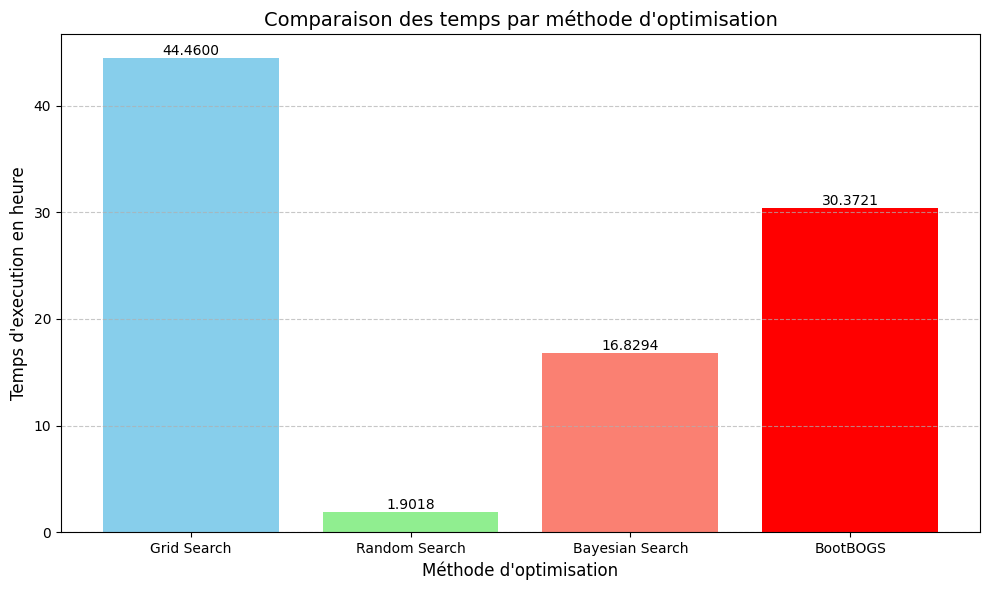

In [ ]:
# 1. Lire les fichiers CSV
grid = pd.read_csv(path_grid)
random = pd.read_csv(path_random)
bayesian = pd.read_csv(path_bayesian)
bayesian_opt = pd.read_csv(path_bootstrap)
bayesian_opt2 = pd.read_csv(path_bootstrap2)
grid_after_bay = pd.read_csv(path_bootbogs)

sum_grid = (grid['training_time'].sum())/3600
sum_random = (random['training_time'].sum())/3600
sum_bayesian = (bayesian['training_time'].sum())/3600
sum_bayesian_opt = ((bayesian_opt['training_time']).sum())/3600
sum_grid_after_bay = (grid_after_bay['training_time'].sum())/3600
sum_bayesian_opt2 = ((bayesian_opt2['training_time']).sum())/3600

bootbogs = sum_grid_after_bay + sum_bayesian_opt

# 3. Préparer les données pour l'histogramme
methodes = ['Grid Search', 'Random Search', 'Bayesian Search', 'BootBOGS']
sums = [sum_grid, sum_random, sum_bayesian, bootbogs]

# 4. Créer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(methodes, sums, color=['skyblue', 'lightgreen', 'salmon', 'red'])

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# 5. Personnaliser le graphique
plt.title('Comparaison des temps par méthode d\'optimisation', fontsize=14)
plt.xlabel('Méthode d\'optimisation', fontsize=12)
plt.ylabel('Temps d\'execution en heure', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 6. Afficher le graphique
plt.tight_layout()
plt.show()

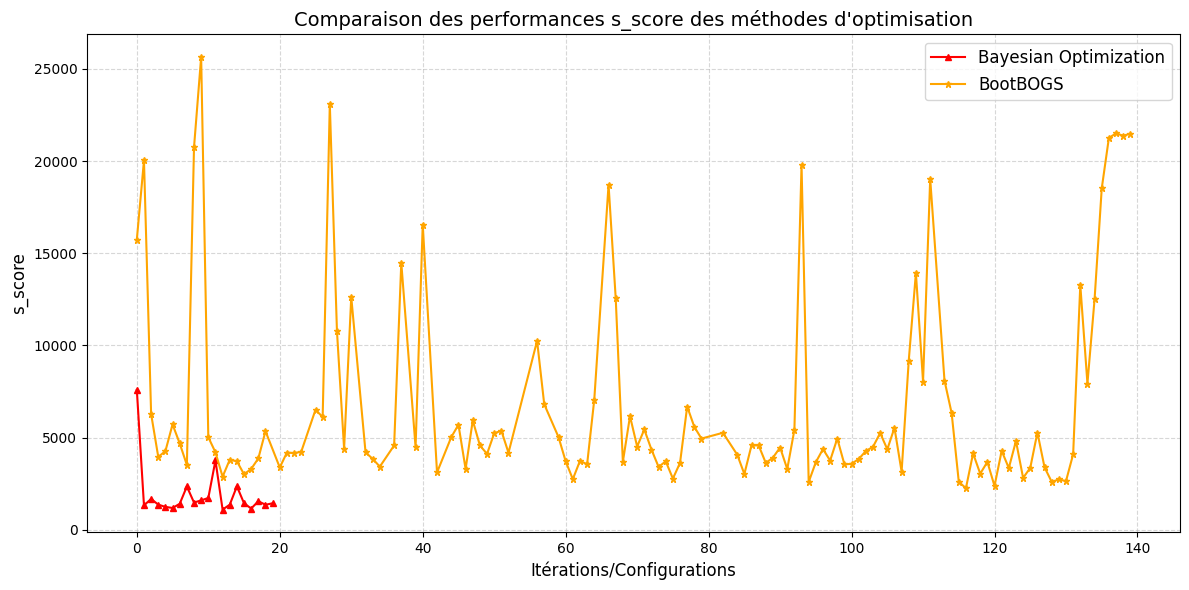

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    return df[mask]

grid = pd.read_csv(path_grid)
random = pd.read_csv(path_random)
bayesian = pd.read_csv(path_bayesian)
bayesian_opt = pd.read_csv(path_bootstrap)
grid_after_bay = pd.read_csv(path_bootbogs)

grid_after_bay = remove_outliers_iqr(grid_after_bay, 's_score')


# Préparer les données pour le tracé
plt.figure(figsize=(12, 6))

# Tracer les courbes de s_score pour chaque méthode
#plt.plot(grid['s_score'], label='Grid Search', color='blue', marker='o', markersize=5)
#plt.plot(random['s-score'], label='Random Search', color='green', marker='s', markersize=5)
plt.plot(bayesian['s_score'], label='Bayesian Optimization', color='red', marker='^', markersize=5)
#plt.plot(bayesian_opt['s_score'], label='Bootstrap Bayesian Search', color='orange', marker='D', markersize=5)
plt.plot(grid_after_bay['s_score'], label='BootBOGS', color='orange', marker='*', markersize=5)
#plt.plot(bayesian_opt['s_score'], label='Bootstrap Bayesian Search', color='orange', marker='D', markersize=5)

# Personnalisation du graphique
plt.title('Comparaison des performances s_score des méthodes d\'optimisation', fontsize=14)
plt.xlabel('Itérations/Configurations', fontsize=12)
plt.ylabel('s_score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher la légende
plt.legend(fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

Mean s_score: 2870.5240
Standard Deviation: 767.7911


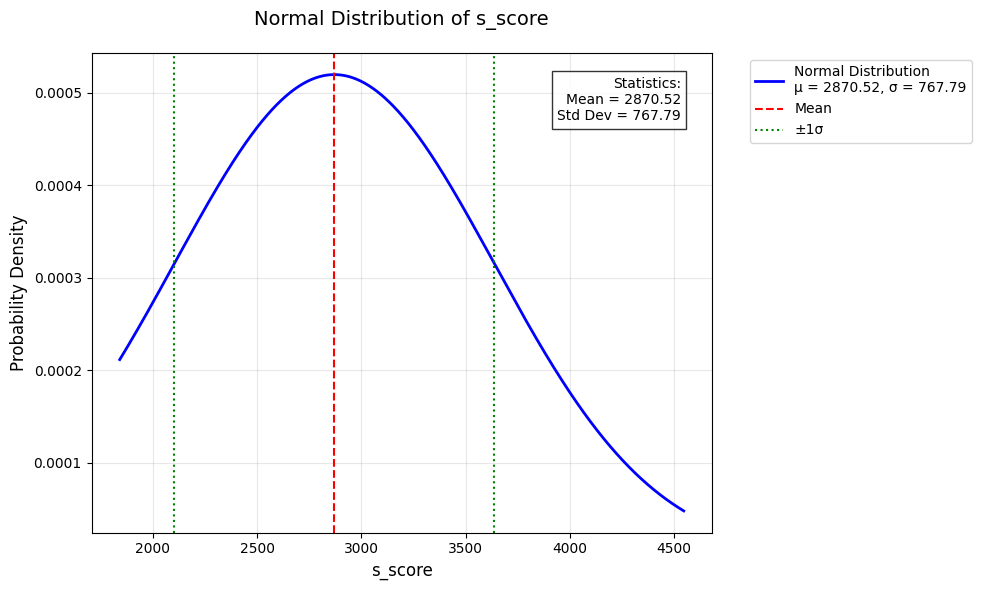

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load and clean the dataset
df = pd.read_csv(path_bootstrap)
df = remove_outliers_iqr(df, 's_score')

# Extract the s_score values
s_scores = df['s_score']

# Compute statistics
mean = np.mean(s_scores)
std = np.std(s_scores)

print(f"Mean s_score: {mean:.4f}")
print(f"Standard Deviation: {std:.4f}")

# Generate x-values for the normal PDF
x = np.linspace(s_scores.min() - 1, s_scores.max() + 1, 1000)
y = norm.pdf(x, mean, std)

# Plot the normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='blue', linewidth=2,
         label=f'Normal Distribution\nμ = {mean:.2f}, σ = {std:.2f}')

# Highlight the mean and ±1 standard deviation
plt.axvline(mean, color='red', linestyle='--', label='Mean')
plt.axvline(mean - std, color='green', linestyle=':', label='±1σ')
plt.axvline(mean + std, color='green', linestyle=':')

# Plot formatting
plt.title('Normal Distribution of s_score', fontsize=14, pad=20)
plt.xlabel('s_score', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Add stats box
stats_text = f"""Statistics:
Mean = {mean:.2f}
Std Dev = {std:.2f}"""
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         va='top', ha='right',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
best_bootbogs

,bootstrap_series,hidden_size,learning_rate,dropout,rmse,s_score,mape,r2,training_time
45,46,64.0,0.0004,0.5,17.391905,1368.717099,30.766054,0.846565,216.660055


Mean s_score: 2428.2577
Standard Deviation: 489.9672


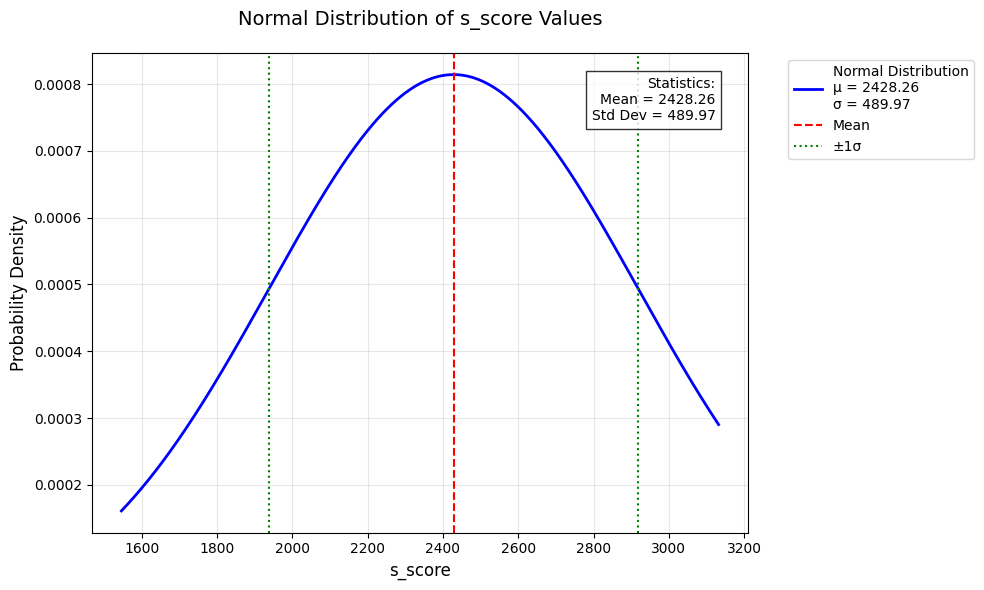

In [ ]:
from scipy.stats import norm

df = pd.read_csv(path_bootstrap)
df = remove_outliers_iqr(df, 's_score')
s_score_data = df['s_score']

mean_s_score = np.mean(s_score_data)
std_s_score = np.std(s_score_data)

print(f"Mean s_score: {mean_s_score:.4f}")
print(f"Standard Deviation: {std_s_score:.4f}")

# Generate x values for plotting
x = np.linspace(min(s_score_data) - 1, max(s_score_data) + 1, 1000)

# Calculate normal distribution PDF
y = norm.pdf(x, mean_s_score, std_s_score)

# Create figure with enhanced visualization
plt.figure(figsize=(10, 6))

plt.plot(x, y,
         label=f'Normal Distribution\nμ = {mean_s_score:.2f}\nσ = {std_s_score:.2f}',
         color='blue',
         linewidth=2)

# Highlight mean and std dev regions
plt.axvline(mean_s_score, color='red', linestyle='--', label='Mean')
plt.axvline(mean_s_score - std_s_score, color='green', linestyle=':', label='±1σ')
plt.axvline(mean_s_score + std_s_score, color='green', linestyle=':')

# Formatting
plt.title('Normal Distribution of s_score Values', fontsize=14, pad=20)
plt.xlabel('s_score', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add text box with statistics
stats_text = f"""Statistics:
Mean = {mean_s_score:.2f}
Std Dev = {std_s_score:.2f}"""
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

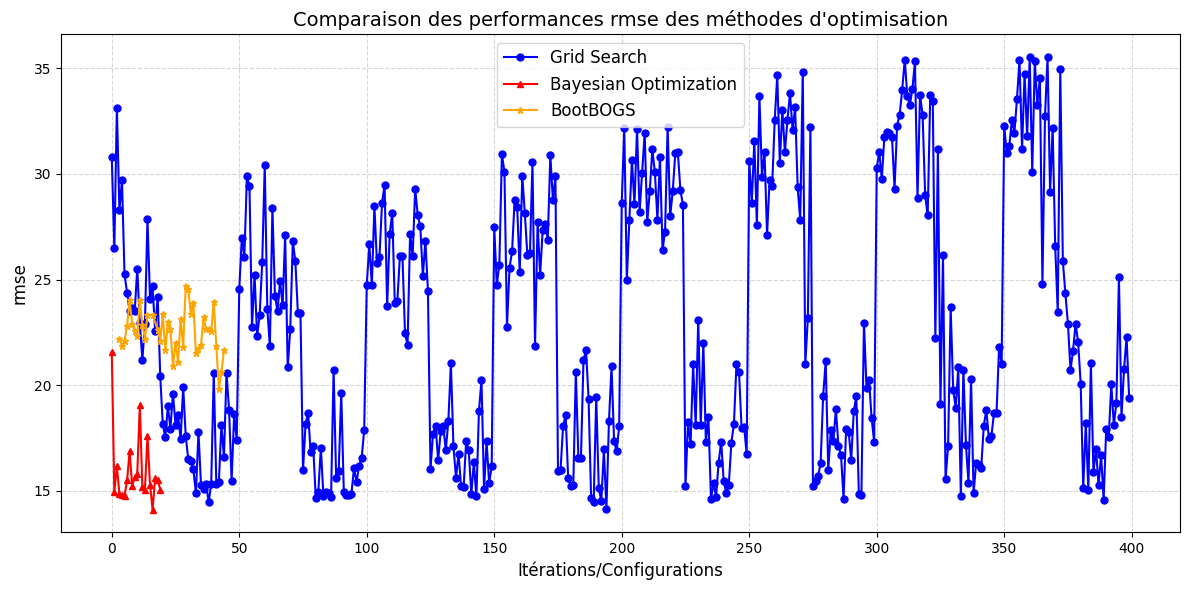

In [ ]:
grid = pd.read_csv(path_grid)
random = pd.read_csv(path_random)
bayesian = pd.read_csv(path_bayesian)
bayesian_opt = pd.read_csv(path_bootstrap)
grid_after_bay = pd.read_csv(path_bootbogs)

grid_after_bay = remove_outliers_iqr(grid_after_bay, 'rmse')

# Préparer les données pour le tracé
plt.figure(figsize=(12, 6))

# Tracer les courbes de rmse pour chaque méthode
plt.plot(grid['rmse'], label='Grid Search', color='blue', marker='o', markersize=5)
#plt.plot(random['s-score'], label='Random Search', color='green', marker='s', markersize=5)
plt.plot(bayesian['rmse'], label='Bayesian Optimization', color='red', marker='^', markersize=5)
#plt.plot(bayesian_opt['rmse'], label='Bootstrap Bayesian Search', color='orange', marker='D', markersize=5)
plt.plot(grid_after_bay['rmse'], label='BootBOGS', color='orange', marker='*', markersize=5)
#plt.plot(bayesian_opt['rmse'], label='Bootstrap Bayesian Search', color='orange', marker='D', markersize=5)

# Personnalisation du graphique
plt.title('Comparaison des performances rmse des méthodes d\'optimisation', fontsize=14)
plt.xlabel('Itérations/Configurations', fontsize=12)
plt.ylabel('rmse', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Afficher la légende
plt.legend(fontsize=12)

# Afficher le graphique
plt.tight_layout()
plt.show()

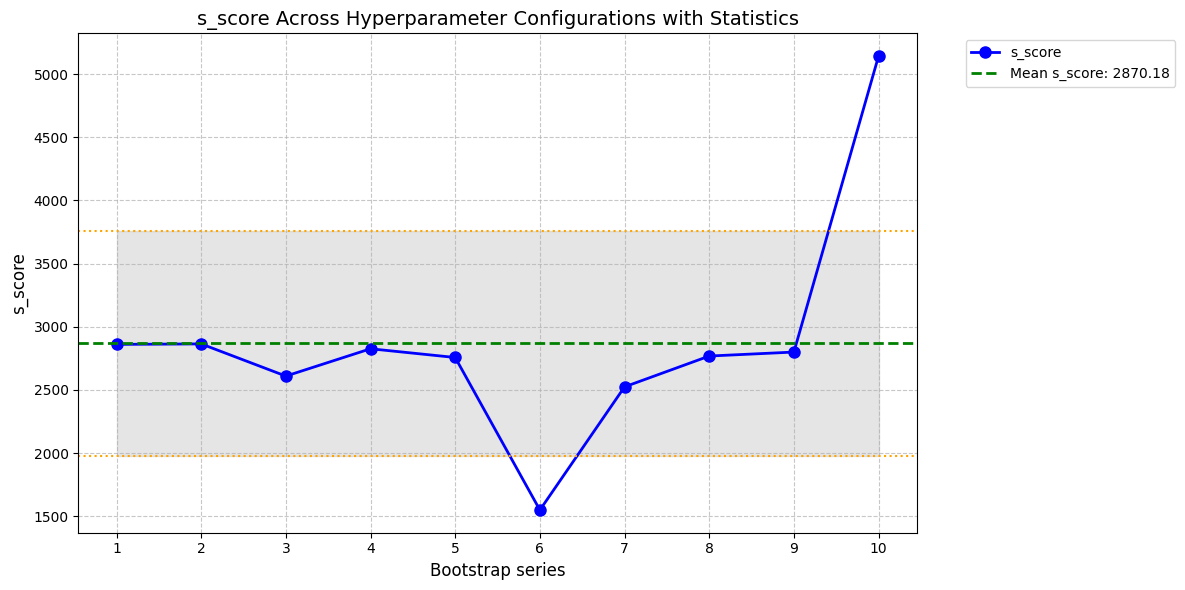

In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    return df[mask]

df = pd.read_csv(path_bootstrap)
plt.figure(figsize=(12, 6))
#df = remove_outliers_iqr(df, 's_score')


# Calculate mean and standard deviation
mean_s_score = df["s_score"].mean()
std_s_score = df["s_score"].std()

# Main plot
plt.plot(
    df["bootstrap_series"],
    df["s_score"],
    marker="o",
    linestyle="-",
    color="blue",
    linewidth=2,
    markersize=8,
    label="s_score"
)

# mean and std deviation
plt.axhline(mean_s_score, color='green', linestyle='--', linewidth=2,
           label=f'Mean s_score: {mean_s_score:.2f}')
plt.axhline(mean_s_score + std_s_score, color='orange', linestyle=':', linewidth=1.5)
plt.axhline(mean_s_score - std_s_score, color='orange', linestyle=':', linewidth=1.5)

# Fill between ±1 std for better visualization
plt.fill_between(df["bootstrap_series"],
                mean_s_score - std_s_score,
                mean_s_score + std_s_score,
                color='gray', alpha=0.2)

# Customize the plot
plt.title("s_score Across Hyperparameter Configurations with Statistics", fontsize=14)
plt.xlabel("Bootstrap series", fontsize=12)
plt.ylabel("s_score", fontsize=12)
plt.xticks(df["bootstrap_series"])
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
bayesian_opt = pd.read_csv(path_bootstrap)
bayesian_opt2 = pd.read_csv(path_bootstrap2)
grid_after_bay = pd.read_csv(path_bootbogs)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[column] >= (Q1 - 1.5 * IQR)) & (df[column] <= (Q3 + 1.5 * IQR))
    filtered_df = df[mask]
    num_outliers = len(df) - len(filtered_df)
    pct_outliers = 100 * num_outliers / len(df)
    return filtered_df, num_outliers, pct_outliers


# Nettoyage + stats
bayesian_opt, n_bayes_opt, pct_bayes_opt = remove_outliers_iqr(bayesian_opt, 'rmse')
bayesian_opt2, n_bayes_opt2, pct_bayes_opt2 = remove_outliers_iqr(bayesian_opt2, 'rmse')
grid_after_bay, n_bootbogs, pct_bootbogs = remove_outliers_iqr(grid_after_bay, 'rmse')

# Affichage
print("Outliers supprimés :")
print(f"Bootstrap 1 : {n_bayes_opt} outliers ({pct_bayes_opt:.2f}%)")
print(f"Bootstrap 2 : {n_bayes_opt2} outliers ({pct_bayes_opt2:.2f}%)")
print(f"Grid  : {n_bootbogs} outliers ({pct_bootbogs:.2f}%)")

Outliers supprimés :
Bootstrap 1 : 3 outliers (30.00%)
Bootstrap 2 : 3 outliers (30.00%)
Grid  : 4 outliers (5.80%)


In [ ]:
df = pd.read_csv(path_bootstrap)
df = remove_outliers_iqr(df, 's_score')

plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation
mean_s_score = df["s_score"].mean()
std_s_score = df["s_score"].std()

# Main plot
plt.plot(
    df["bootstrap_series"],
    df["s_score"],
    marker="o",
    linestyle="-",
    color="blue",
    linewidth=2,
    markersize=8,
    label="s_score"
)

# mean and std deviation
plt.axhline(mean_s_score, color='green', linestyle='--', linewidth=2,
           label=f'Mean s_score: {mean_s_score:.2f}')
plt.axhline(mean_s_score + std_s_score, color='orange', linestyle=':', linewidth=1.5)
plt.axhline(mean_s_score - std_s_score, color='orange', linestyle=':', linewidth=1.5)

# Fill between ±1 std for better visualization
plt.fill_between(df["bootstrap_series"],
                mean_s_score - std_s_score,
                mean_s_score + std_s_score,
                color='gray', alpha=0.2)

# Customize the plot
plt.title("s_score Across Hyperparameter Configurations with Statistics", fontsize=14)
plt.xlabel("Bootstrap series", fontsize=12)
plt.ylabel("s_score", fontsize=12)
plt.xticks(df["bootstrap_series"])
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.show()

NameError: name 'remove_outliers_iqr' is not defined

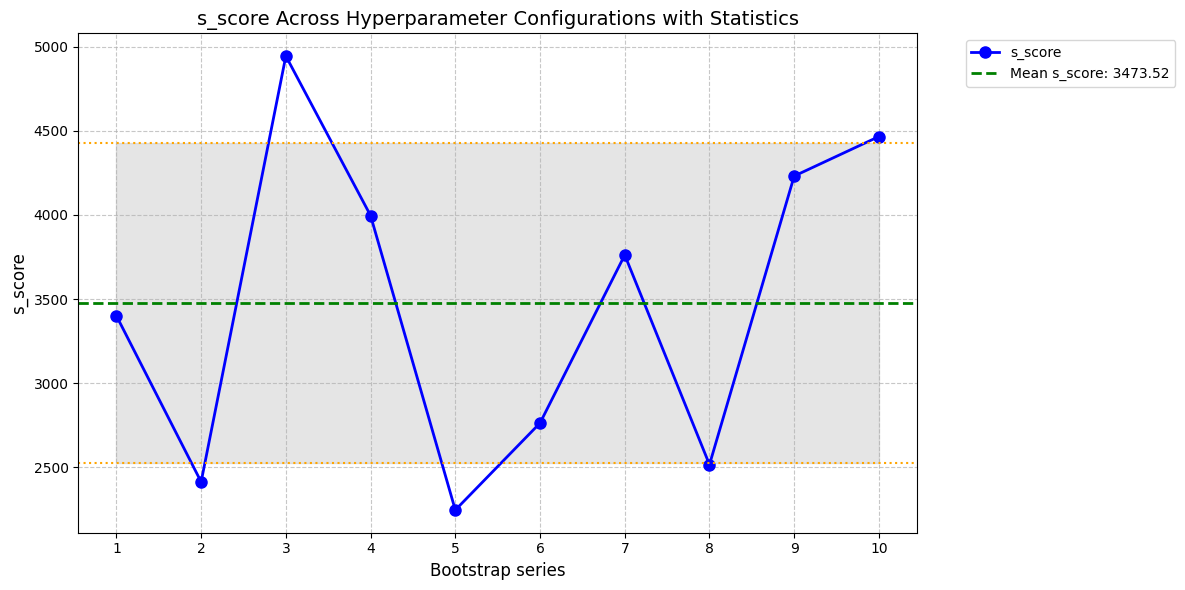

In [ ]:
df = pd.read_csv(path_bootstrap)
plt.figure(figsize=(12, 6))

# Calculate mean and standard deviation
mean_s_score = df["s_score"].mean()
std_s_score = df["s_score"].std()

# Main plot
plt.plot(
    df["bootstrap_series"],
    df["s_score"],
    marker="o",
    linestyle="-",
    color="blue",
    linewidth=2,
    markersize=8,
    label="s_score"
)

# mean and std deviation
plt.axhline(mean_s_score, color='green', linestyle='--', linewidth=2,
           label=f'Mean s_score: {mean_s_score:.2f}')
plt.axhline(mean_s_score + std_s_score, color='orange', linestyle=':', linewidth=1.5)
plt.axhline(mean_s_score - std_s_score, color='orange', linestyle=':', linewidth=1.5)

# Fill between ±1 std for better visualization
plt.fill_between(df["bootstrap_series"],
                mean_s_score - std_s_score,
                mean_s_score + std_s_score,
                color='gray', alpha=0.2)

# Customize the plot
plt.title("s_score Across Hyperparameter Configurations with Statistics", fontsize=14)
plt.xlabel("Bootstrap series", fontsize=12)
plt.ylabel("s_score", fontsize=12)
plt.xticks(df["bootstrap_series"])
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.show()

In [ ]:
best_bootbogs

,bootstrap_series,hidden_size,learning_rate,dropout,rmse,s_score,mape,r2,training_time
42,43,128.0,0.00032,0.5,19.834856,2976.461826,43.99578,0.800434,242.156474


In [ ]:
grid = pd.read_csv(path_grid)
random = pd.read_csv(path_random)
bayesian = pd.read_csv(path_bayesian)
grid_after_bay = pd.read_csv(path_bootbogs)


# Trouver la plus petite valeur de 's_score'
min_s_score_grid = grid['s_score'].min()
min_s_score_random = random['s-score'].min()
min_s_score_bayesian = bayesian['s_score'].min()
min_s_score_grid_after_bay = grid_after_bay['s_score'].min()

print('grid Search',min_s_score_grid)
print('random Search',min_s_score_random)
print('bayesian Search',min_s_score_bayesian)
print('bootbogs',min_s_score_grid_after_bay)

# Trouver la ligne correspondante
best_grid_row = grid[grid['s_score'] == min_s_score_grid]
best_random_row = random[random['s-score'] == min_s_score_random]
best_bayesian_row = bayesian[bayesian['s_score'] == min_s_score_bayesian]
best_grid_after_row = grid_after_bay[grid_after_bay['s_score'] == min_s_score_grid_after_bay]

print(best_grid_after_row['learning_rate'].values)

grid Search 940.8831881934332
random Search 1453.8971186660292
bayesian Search 1101.214229497421
bootbogs 1649.3490291786104
[0.0063]


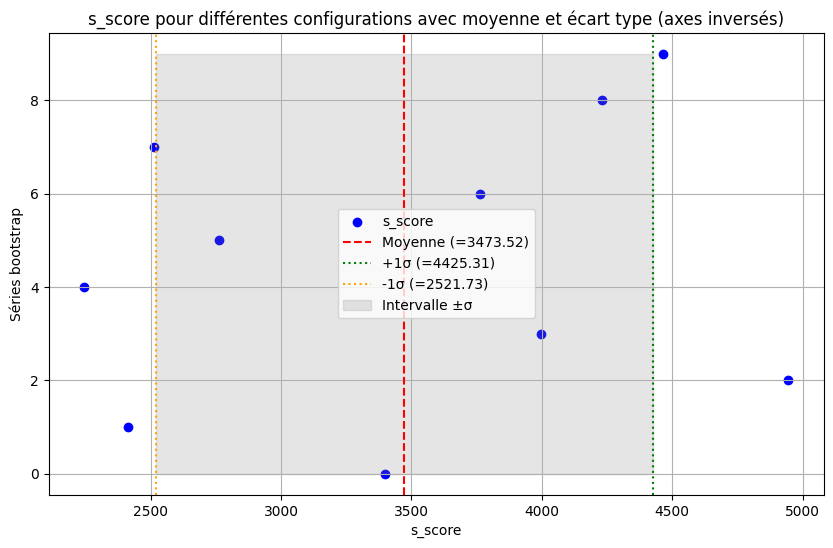

In [ ]:
# Charger les données
data = pd.read_csv(path_bootstrap)

# Créer un DataFrame
df = pd.DataFrame(data)

# Calculer la moyenne et l'écart type de la colonne 's_score'
mean_s_score = df['s_score'].mean()
std_s_score = df['s_score'].std()

# Tracer le graphique avec les axes inversés
plt.figure(figsize=(10, 6))
plt.scatter(df['s_score'], df.index, color='blue', label='s_score')
#plt.plot(df['s_score'], df.index, color='blue', label='s_score')  # Inversion des axes


# Ajouter la moyenne et les intervalles ±σ
plt.axvline(x=mean_s_score, color='red', linestyle='--', label=f'Moyenne (={mean_s_score:.2f})')  # Ligne verticale pour la moyenne
plt.axvline(x=mean_s_score + std_s_score, color='green', linestyle=':', label=f'+1σ (={mean_s_score + std_s_score:.2f})')  # Ligne verticale pour +1σ
plt.axvline(x=mean_s_score - std_s_score, color='orange', linestyle=':', label=f'-1σ (={mean_s_score - std_s_score:.2f})')  # Ligne verticale pour -1σ

# Remplir la zone entre ±σ
plt.fill_betweenx(df.index, mean_s_score - std_s_score, mean_s_score + std_s_score, color='gray', alpha=0.2, label='Intervalle ±σ')  # Remplissage vertical

# Ajouter des labels et un titre
plt.ylabel('Séries bootstrap')  # L'axe des y devient l'axe des séries bootstrap
plt.xlabel('s_score')  # L'axe des x devient l'axe des s_score
plt.title('s_score pour différentes configurations avec moyenne et écart type (axes inversés)')
plt.legend()
plt.grid(True)
plt.show()

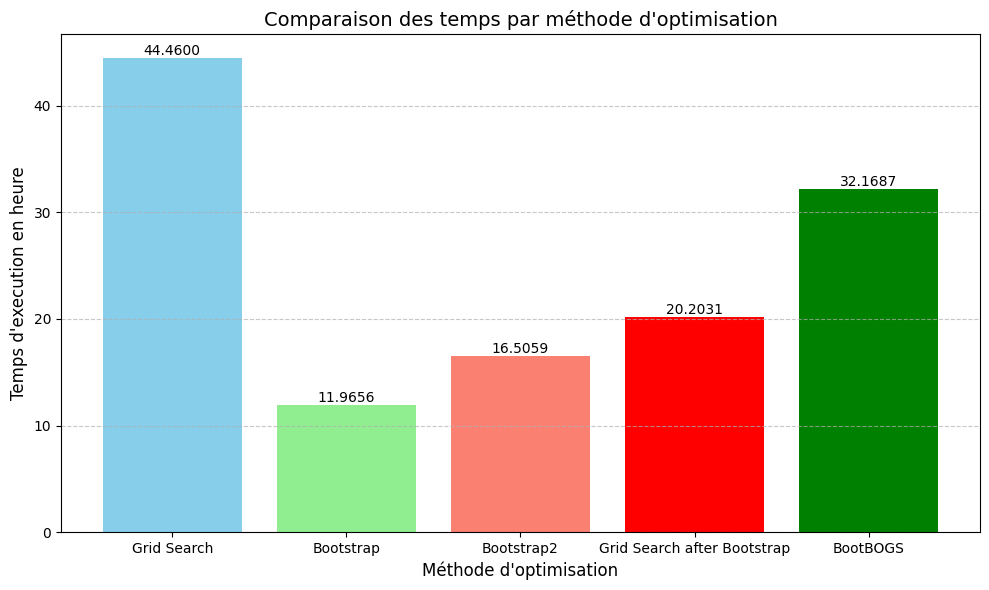

In [ ]:
# 1. Lire les fichiers CSV
grid = pd.read_csv(path_grid)
bayesian_opt = pd.read_csv(path_bootstrap)
bayesian_opt2 = pd.read_csv(path_bootstrap2)
grid_after_bay = pd.read_csv(path_bootbogs)

sum_grid = (grid['training_time'].sum())/3600
sum_bayesian_opt = ((bayesian_opt['training_time']).sum())/3600
sum_grid_after_bay = (grid_after_bay['training_time'].sum())/3600
sum_bayesian_opt2 = ((bayesian_opt2['training_time']).sum())/3600

bootbogs = sum_grid_after_bay + sum_bayesian_opt

# 3. Préparer les données pour l'histogramme
methodes = ['Grid Search', 'Bootstrap', 'Bootstrap2', 'Grid Search after Bootstrap', 'BootBOGS']
sums = [sum_grid, sum_bayesian_opt, sum_bayesian_opt2, sum_grid_after_bay, bootbogs]

# 4. Créer l'histogramme
plt.figure(figsize=(10, 6))
bars = plt.bar(methodes, sums, color=['skyblue', 'lightgreen', 'salmon', 'red', 'green'])

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# 5. Personnaliser le graphique
plt.title('Comparaison des temps par méthode d\'optimisation', fontsize=14)
plt.xlabel('Méthode d\'optimisation', fontsize=12)
plt.ylabel('Temps d\'execution en heure', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 6. Afficher le graphique
plt.tight_layout()
plt.show()

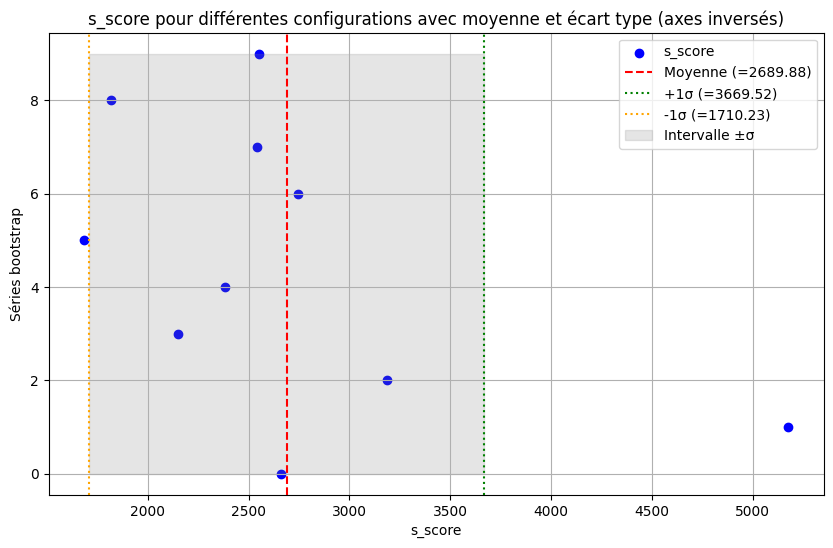

In [ ]:
# Charger les données
data = pd.read_csv(path_bootstrap2)

# Créer un DataFrame
df = pd.DataFrame(data)

# Calculer la moyenne et l'écart type de la colonne 's_score'
mean_s_score = df['s_score'].mean()
std_s_score = df['s_score'].std()

# Tracer le graphique avec les axes inversés
plt.figure(figsize=(10, 6))
plt.scatter(df['s_score'], df.index, color='blue', label='s_score')
#plt.plot(df['s_score'], df.index, color='blue', label='s_score')  # Inversion des axes


# Ajouter la moyenne et les intervalles ±σ
plt.axvline(x=mean_s_score, color='red', linestyle='--', label=f'Moyenne (={mean_s_score:.2f})')  # Ligne verticale pour la moyenne
plt.axvline(x=mean_s_score + std_s_score, color='green', linestyle=':', label=f'+1σ (={mean_s_score + std_s_score:.2f})')  # Ligne verticale pour +1σ
plt.axvline(x=mean_s_score - std_s_score, color='orange', linestyle=':', label=f'-1σ (={mean_s_score - std_s_score:.2f})')  # Ligne verticale pour -1σ

# Remplir la zone entre ±σ
plt.fill_betweenx(df.index, mean_s_score - std_s_score, mean_s_score + std_s_score, color='gray', alpha=0.2, label='Intervalle ±σ')  # Remplissage vertical

# Ajouter des labels et un titre
plt.ylabel('Séries bootstrap')  # L'axe des y devient l'axe des séries bootstrap
plt.xlabel('s_score')  # L'axe des x devient l'axe des s_score
plt.title('s_score pour différentes configurations avec moyenne et écart type (axes inversés)')
plt.legend()
plt.grid(True)
plt.show()

# Test perf

In [ ]:

def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=int(nodes_per_layer), activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))  # Output for regression
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

hidden_size = best_bootbogs.iloc[0, 1]
dropout = best_bootbogs.iloc[0, 3]
learning_rate = round(best_bootbogs.iloc[0, 2], 5)
start_time = time.time()

# Build and train model
model = model_lstm_1layer(input_shape, hidden_size, dropout, activation, learning_rate)

history = model.fit(
    train_array, label_array,
    validation_data=(test_array, test_rul),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

# Evaluate
y_pred = model.predict(test_array)
rmse = root_mean_squared_error(test_rul, y_pred)
score = compute_s_score(test_rul, y_pred)
mape = compute_MAPE(test_rul, y_pred)
r2 = r2_score(test_rul, y_pred)
training_time = time.time() - start_time

print(f"→ RMSE: {rmse:.4f}, Time: {training_time:.2f}s")

# Save to results
print(f"hidden_size: {hidden_size}, learning_rate: {learning_rate}, dropout: {dropout}, "
      f"rmse: {rmse:.4f}, s-score: {score:.2f}, mape: {mape:.2f}, "
      f"r2: {r2:.4f}, training_time: {training_time:.2f}s")

In [ ]:
import os
import random
import tensorflow as tf
path_bootstrap = '/content/drive/Othercomputers/Mon ordinateur/Malick/data/resultats_test/results.csv'


SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
results_all = pd.DataFrame()

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=int(nodes_per_layer), activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))  # Output for regression
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

combinations = [
    {"hidden_size": 128, "learning_rate": 0.004642, "dropout": 0.5},
    {"hidden_size": 64,  "learning_rate": 0.003145, "dropout": 0.3},
    {"hidden_size": 192, "learning_rate": 0.004269, "dropout": 0.5},
    {"hidden_size": 160, "learning_rate": 0.0063,   "dropout": 0.2},
    {"hidden_size": 256, "learning_rate": 0.00388,  "dropout": 0.4},
    {"hidden_size": 224, "learning_rate": 0.001,    "dropout": 0.3},
    {"hidden_size": 128, "learning_rate": 0.000442, "dropout": 0.3},
    {"hidden_size": 128, "learning_rate": 0.00052,  "dropout": 0.5},
    {"hidden_size": 160, "learning_rate": 0.00055,  "dropout": 0.4},
    {"hidden_size": 128, "learning_rate": 0.001,    "dropout": 0.3},
    {"hidden_size": 160, "learning_rate": 0.00117,  "dropout": 0.5},
    {"hidden_size": 128, "learning_rate": 0.0031192,"dropout": 0.2},
    {"hidden_size": 224, "learning_rate": 0.00063,  "dropout": 0.1}
]
for i, combo in enumerate(combinations, start=1):

    hidden_size = combo["hidden_size"]
    learning_rate = combo["learning_rate"]
    dropout = combo["dropout"]

    start_time = time.time()

    # Build and train model
    model = model_lstm_1layer(input_shape, hidden_size, dropout, activation, learning_rate)

    history = model.fit(
        train_array, label_array,
        validation_data=(test_array, test_rul),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluate
    y_pred = model.predict(test_array)
    rmse = root_mean_squared_error(test_rul, y_pred)
    s_score = compute_s_score(test_rul, y_pred)
    mape = compute_MAPE(test_rul, y_pred)
    r2 = r2_score(test_rul, y_pred)
    training_time = time.time() - start_time

    print(f"→ RMSE: {rmse:.4f}, Time: {training_time:.2f}s")

    # Save to results
    print(f"hidden_size: {hidden_size}, learning_rate: {learning_rate}, dropout: {dropout}, "
        f"rmse: {rmse:.4f}, s-score: {score:.2f}, mape: {mape:.2f}, "
        f"r2: {r2:.4f}, training_time: {training_time:.2f}s")
    results_all = pd.concat([results_all, pd.DataFrame([{
      'bootstrap_series': i + 1,
      'hidden_size': combo['hidden_size'],
      'learning_rate': combo['learning_rate'],
      'dropout': combo['dropout'],
      'rmse': rmse,
      's_score': s_score,
      'mape': mape,
      'r2': r2,
      'training_time': training_time
  }])], ignore_index=True)
    print(results_all)

  # Sauvegarder les résultats dans un fichier CSV après chaque itération
    results_all.to_csv(path_bootstrap, index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
→ RMSE: 15.0931, Time: 94.94s


NameError: name 'score' is not defined

In [ ]:
import os
import random
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
results_all = pd.DataFrame()

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

def model_lstm_1layer(input_shape, nodes_per_layer, dropout, activation, learning_rate):
    model = Sequential()
    model.add(LSTM(units=int(nodes_per_layer), activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(256))
    model.add(Dense(1))  # Output for regression
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model

combinations = [
    {"method": "B1SLRA10", "hidden_size": 32, "learning_rate": 0.0029, "dropout": 0.5},
    {"method": "Random Search", "hidden_size": 160,  "learning_rate": 0.000659, "dropout": 0.3},
    {"method": "Bayesian Search", "hidden_size": 96, "learning_rate": 0.003686, "dropout": 0.4},
    {"method": "B2SLRA20", "hidden_size": 96,  "learning_rate": 0.00036, "dropout": 0.4},


    {"method": "Grid Search", "hidden_size": 128, "learning_rate": 0.00032, "dropout": 0.5},
    {"method": "B1SLRA20", "hidden_size": 128, "learning_rate": 0.00032, "dropout": 0.5},
]
for i, combo in enumerate(combinations, start=1):

    hidden_size = combo["hidden_size"]
    learning_rate = combo["learning_rate"]
    dropout = combo["dropout"]

    start_time = time.time()

    # Build and train model
    model = model_lstm_1layer(input_shape, hidden_size, dropout, activation, learning_rate)

    history = model.fit(
        train_array, label_array,
        validation_data=(test_array, test_rul),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Evaluate
    y_pred = model.predict(test_array)
    rmse = root_mean_squared_error(test_rul, y_pred)
    s_score = compute_s_score(test_rul, y_pred)
    mape = compute_MAPE(test_rul, y_pred)
    r2 = r2_score(test_rul, y_pred)
    test_time = time.time() - start_time

    print(f"→ RMSE: {rmse:.4f}, Time: {test_time:.2f}s")

    # Save to results
    # print(f"hidden_size: {hidden_size}, learning_rate: {learning_rate}, dropout: {dropout}, "
    #     f"rmse: {rmse:.4f}, s-score: {score:.2f}, mape: {mape:.2f}, "
    #     f"r2: {r2:.4f}, test_time: {test_time:.2f}s")
    results_all = pd.concat([results_all, pd.DataFrame([{
      'bootstrap_series': i + 1,
      'method': combo['method'],
      'hidden_size': combo['hidden_size'],
      'learning_rate': combo['learning_rate'],
      'dropout': combo['dropout'],
      'rmse': rmse,
      's_score': s_score,
      'mape': mape,
      'r2': r2,
      'test_time': test_time
  }])], ignore_index=True)
    print(results_all)

  # Sauvegarder les résultats dans un fichier CSV après chaque itération
    #results_all.to_csv("C:/Users/RA-RV/Documents/Malick/data/EO/fd004_resultats.csv", index=False)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
→ RMSE: 15.3258, Time: 182.47s
   bootstrap_series    method  hidden_size  learning_rate  dropout       rmse  \
0                 2  B1SLRA10           32         0.0029      0.5  15.325751   

      s_score       mape        r2   test_time  
0  992.942471  28.750055  0.880856  182.468988  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
→ RMSE: 14.0265, Time: 187.21s
   bootstrap_series         method  hidden_size  learning_rate  dropout  \
0                 2       B1SLRA10           32       0.002900      0.5   
1                 3  Random Search          160       0.000659      0.3   

        rmse     s_score       mape        r2   test_time  
0  15.325751  992.942471  28.750055  0.880856  182.468988  
1  14.026473  859.608660  19.044467  0.900201  187.205193  


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
→ RMSE: 15.2122, Time: 182.43s
   bootstrap_series           method  hidden_size  learning_rate  dropout  \
0                 2         B1SLRA10           32       0.002900      0.5   
1                 3    Random Search          160       0.000659      0.3   
2                 4  Bayesian Search           96       0.003686      0.4   

        rmse     s_score       mape        r2   test_time  
0  15.325751  992.942471  28.750055  0.880856  182.468988  
1  14.026473  859.608660  19.044467  0.900201  187.205193  
2  15.212224  995.167952  20.276829  0.882615  182.429110  


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
→ RMSE: 16.3363, Time: 186.06s
   bootstrap_series           method  hidden_size  learning_rate  dropout  \
0                 2         B1SLRA10           32       0.002900      0.5   
1                 3    Random Search          160       0.000659      0.3   
2                 4  Bayesian Search           96       0.003686      0.4   
3                 5         B2SLRA20           96       0.000360      0.4   

        rmse      s_score       mape        r2   test_time  
0  15.325751   992.942471  28.750055  0.880856  182.468988  
1  14.026473   859.608660  19.044467  0.900201  187.205193  
2  15.212224   995.167952  20.276829  0.882615  182.429110  
3  16.336272  1312.303862  25.202845  0.864626  186.063548  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
→ RMSE: 16.5962, Time: 180.92s
   bootstrap_series           method  hidden_size  learning_rate  dropout  \
0                 2         B1SLRA10           32       0.002900      0.5   
1                